In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import pathlib
import time
import datetime
import numpy as np
import scipy.ndimage
from matplotlib.colors import ListedColormap

from matplotlib import pyplot as plt
from IPython import display

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!apt-get install unrar
!pip install rarfile

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
# Path to the .rar file
rar_file_path = "/content/drive/MyDrive/filtered_model_data.rar"

# Destination folder for extracted files
extract_to = "/content/myData"

# Ensure the destination directory exists
os.makedirs(extract_to, exist_ok=True)

# Extract using unrar
!unrar x -r {rar_file_path} {extract_to}

Streaming output truncated to the last 5000 lines.
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_aug26.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug3257.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug49.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug498.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_2_NoInf_NoReflowN_randAug821.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_3_NoInf_NoReflowN.npy      99%  OK 
Extracting  /content/myData/filtered_model_data/masks/train/EMIDEC_Case_N006_slice_3_NoInf_NoReflowN_randAug1814.npy      99%

In [5]:
# Path to the images directory
train_images_path = "/content/myData/filtered_model_data/images/train"

# List all files in the images directory
train_image_files = sorted(os.listdir(train_images_path))

# Open the first .npy image
first_image_path = os.path.join(train_images_path, train_image_files[0])
image_array = np.load(first_image_path)  # Load the NumPy array

# Print shape and number of channels
print("Image shape:", image_array.shape)  # (height, width, channels) or (height, width)
if image_array.ndim == 2:
    print("Number of channels: 1 (grayscale)")
else:
    print("Number of channels:", image_array.shape[-1])  # Last dimension represents channels

Image shape: (128, 128)
Number of channels: 1 (grayscale)


In [6]:
  # Paths to the images and masks directories
train_images_path = "/content/myData/filtered_model_data/images/train"
train_masks_path = "/content/myData/filtered_model_data/masks/train"
test_images_path = "/content/myData/filtered_model_data/images/test"
test_masks_path = "/content/myData/filtered_model_data/masks/test"

# List and sort files to ensure they match
train_image_files = sorted(os.listdir(train_images_path))
train_mask_files = sorted(os.listdir(train_masks_path))
test_image_files = sorted(os.listdir(test_images_path))
test_mask_files = sorted(os.listdir(test_masks_path))

In [7]:
def load_dataset(images_path, masks_path):
    images = []
    masks = []
    filenames = []

    # List all files in sorted order to ensure proper alignment
    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    for img_file, mask_file in zip(image_files, mask_files):
        # Full paths
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        # Load images and masks as NumPy arrays
        img = np.load(img_path)  # Shape: (H, W) or (H, W, C)
        mask = np.load(mask_path)  # Shape: (H, W) or (H, W, C)

        # Append to lists
        images.append(img)
        masks.append(mask)
        filenames.append(img_file)


    # Convert lists to tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)  # Shape: (N, H, W, 1)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)  # Shape: (N, H, W, 1)

    return images, masks, filenames


In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

In [9]:
# Load dataset
train_images_tensor, train_masks_tensor, train_filenames = load_dataset(train_images_path, train_masks_path)
test_images_tensor, test_masks_tensor, test_filenames = load_dataset(test_images_path, test_masks_path)
train_images_tensor = tf.expand_dims(train_images_tensor, axis=-1)
train_masks_tensor = tf.expand_dims(train_masks_tensor, axis=-1)
test_images_tensor = tf.expand_dims(test_images_tensor, axis=-1)
test_masks_tensor = tf.expand_dims(test_masks_tensor, axis=-1)



# Check shapes
print(f"Train Images Tensor Shape: {train_images_tensor.shape}, dtype: {train_images_tensor.dtype}")
print(f"Train Masks Tensor Shape: {train_masks_tensor.shape}, dtype: {train_masks_tensor.dtype}")
print(f"Test Images Tensor Shape: {test_images_tensor.shape}, dtype: {test_images_tensor.dtype}")
print(f"Test Masks Tensor Shape: {test_masks_tensor.shape}, dtype: {test_masks_tensor.dtype}")

Train Images Tensor Shape: (5000, 128, 128, 1), dtype: <dtype: 'float32'>
Train Masks Tensor Shape: (5000, 128, 128, 1), dtype: <dtype: 'float32'>
Test Images Tensor Shape: (99, 128, 128, 1), dtype: <dtype: 'float32'>
Test Masks Tensor Shape: (99, 128, 128, 1), dtype: <dtype: 'float32'>


In [10]:
# Check counts after augmentation
inf_count = sum(1 for f in train_filenames if '_Inf_' in f)
noinf_count = sum(1 for f in train_filenames if '_NoInf_' in f)
print(f"Inf/NoInf Balance: {inf_count} vs {noinf_count}")

reflowy_count = sum(1 for f in train_filenames if 'NoReflowY' in f)
reflown_count = sum(1 for f in train_filenames if 'NoReflowN' in f)
print(f"NoReflowY/NoReflowN Balance: {reflowy_count} vs {reflown_count}")

Inf/NoInf Balance: 2501 vs 2499
NoReflowY/NoReflowN Balance: 2291 vs 2709


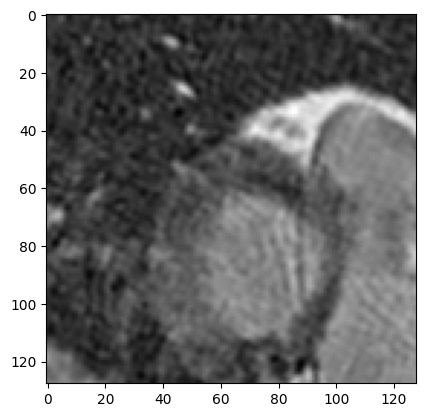

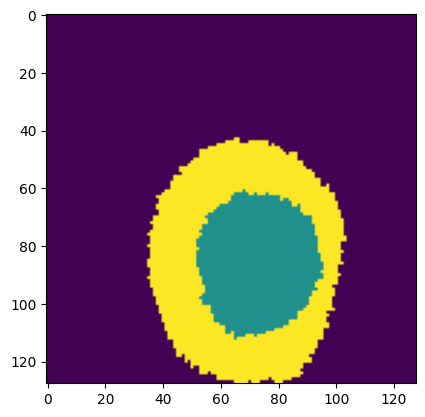

In [11]:
re = train_images_tensor[150]
inp = train_masks_tensor[150]
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(re, cmap='gray')
plt.figure()
plt.imshow(inp)

In [12]:
print(f"Image value range: min={np.min(re)}, max={np.max(re)}")

Image value range: min=1825.4344482421875, max=3094.86083984375


In [13]:
# Check shapes
print(f"Train Images Tensor Shape: {train_images_tensor.shape}, dtype: {train_images_tensor.dtype}")
print(f"Train Masks Tensor Shape: {train_masks_tensor.shape}, dtype: {train_masks_tensor.dtype}")
print(f"Test Images Tensor Shape: {test_images_tensor.shape}, dtype: {test_images_tensor.dtype}")
print(f"Test Masks Tensor Shape: {test_masks_tensor.shape}, dtype: {test_masks_tensor.dtype}")

Train Images Tensor Shape: (5000, 128, 128, 1), dtype: <dtype: 'float32'>
Train Masks Tensor Shape: (5000, 128, 128, 1), dtype: <dtype: 'float32'>
Test Images Tensor Shape: (99, 128, 128, 1), dtype: <dtype: 'float32'>
Test Masks Tensor Shape: (99, 128, 128, 1), dtype: <dtype: 'float32'>


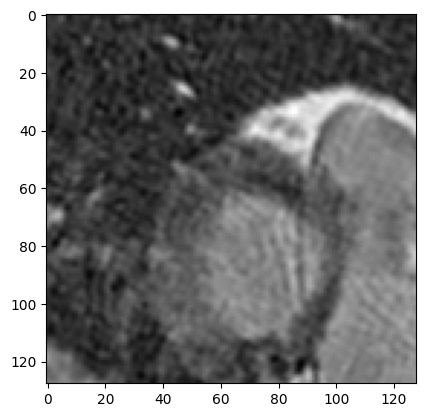

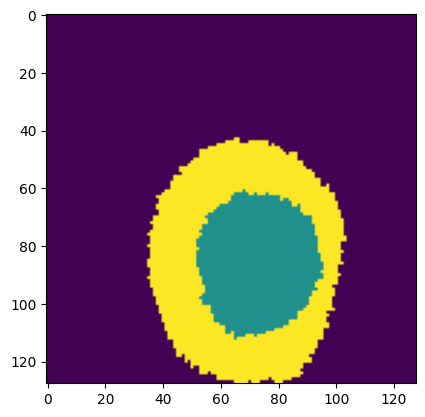

In [14]:
re = train_images_tensor[150]
inp = train_masks_tensor[150]
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(re, cmap='gray')
plt.figure()
plt.imshow(inp)

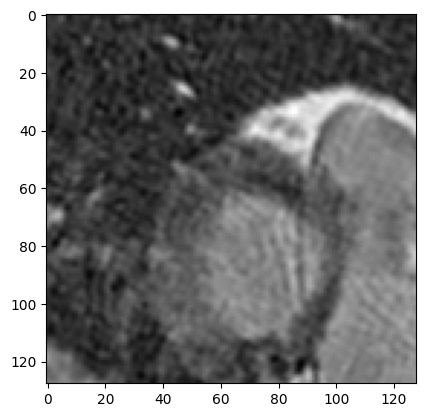

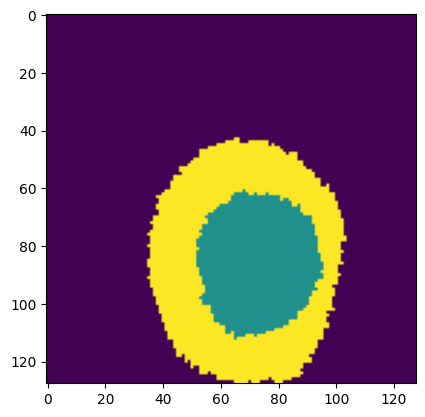

In [15]:
re = train_images_tensor[150]
inp = train_masks_tensor[150]
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(re, cmap='gray')
plt.figure()
plt.imshow(inp)

In [16]:
# The facade training set consist of 400 images
BUFFER_SIZE = len(train_images_tensor)
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [17]:
# Normalizing the images to [-1, 1]
def normalize(image):
  min_val = np.min(image)
  max_val = np.max(image)

  if max_val == min_val:  # Avoid division by zero
      return np.zeros_like(image)  # If constant image, return all zeros in [-1,1] range

  return 2 * (image - min_val) / (max_val - min_val) - 1

In [18]:
train_images_tensor = normalize(train_images_tensor)
test_images_tensor = normalize(test_images_tensor)

In [19]:
print(train_images_tensor.shape)

(5000, 128, 128, 1)


In [20]:
print(f"Image value range: min={np.min(train_images_tensor[30])}, max={np.max(train_images_tensor[30])}")

Image value range: min=-0.12996864318847656, max=0.5644122362136841


In [21]:
# Create tf.data.Dataset objects for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_masks_tensor, train_images_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_masks_tensor, test_images_tensor))

# Optional: Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Train dataset size: {len(train_images_tensor)}")
print(f"Test dataset size: {len(test_images_tensor)}")

Train dataset size: 5000
Test dataset size: 99


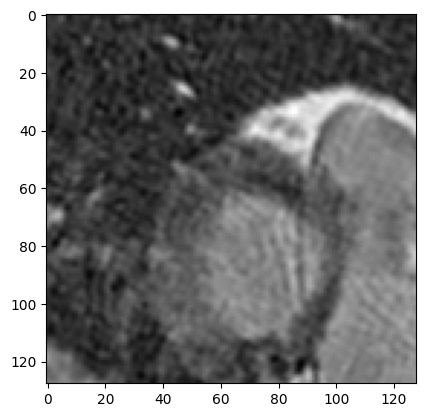

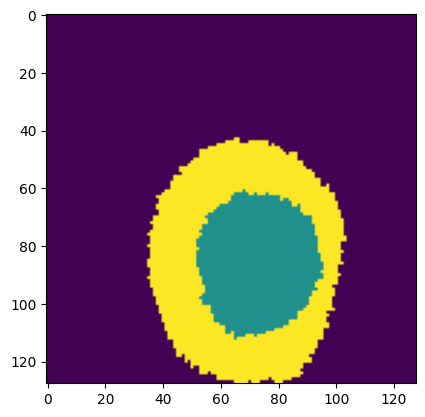

In [22]:
re = train_images_tensor[150]
inp = train_masks_tensor[150]
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(re, cmap='gray')
plt.figure()
plt.imshow(inp)

In [23]:
OUTPUT_CHANNELS = 1

In [24]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [25]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(re, 0))
print (down_result.shape)

(1, 64, 64, 3)


In [26]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [27]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [28]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64)
        downsample(128, 4),  # (batch_size, 32, 32, 128)
        downsample(256, 4),  # (batch_size, 16, 16, 256)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(256, 4),  # (batch_size, 16, 16, 512)
        upsample(128, 4),  # (batch_size, 32, 32, 256)
        upsample(64, 4),  # (batch_size, 64, 64, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 128, 128, 1)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [29]:
generator = Generator()
generator.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64, 64,    │      1,024 │ input_layer_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 32, 32,    │    131,584 │ sequential_2[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 16, 16,    │    525,312 │ sequential_3[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 8, 8, 512) │  2,099,200 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 4, 4, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 2, 2, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 4, 4, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 8, 8, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 16, 16,    │  4,195,328 │ concatenate_1[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 32, 32,    │  1,049,088 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ sequential_11[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 64, 64,    │    262,400 │ concatenate_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ sequential_12[0]

 Total params: 29,245,697 (111.56 MB)

 Trainable params: 29,238,913 (111.54 MB)

 Non-trainable params: 6,784 (26.50 KB)

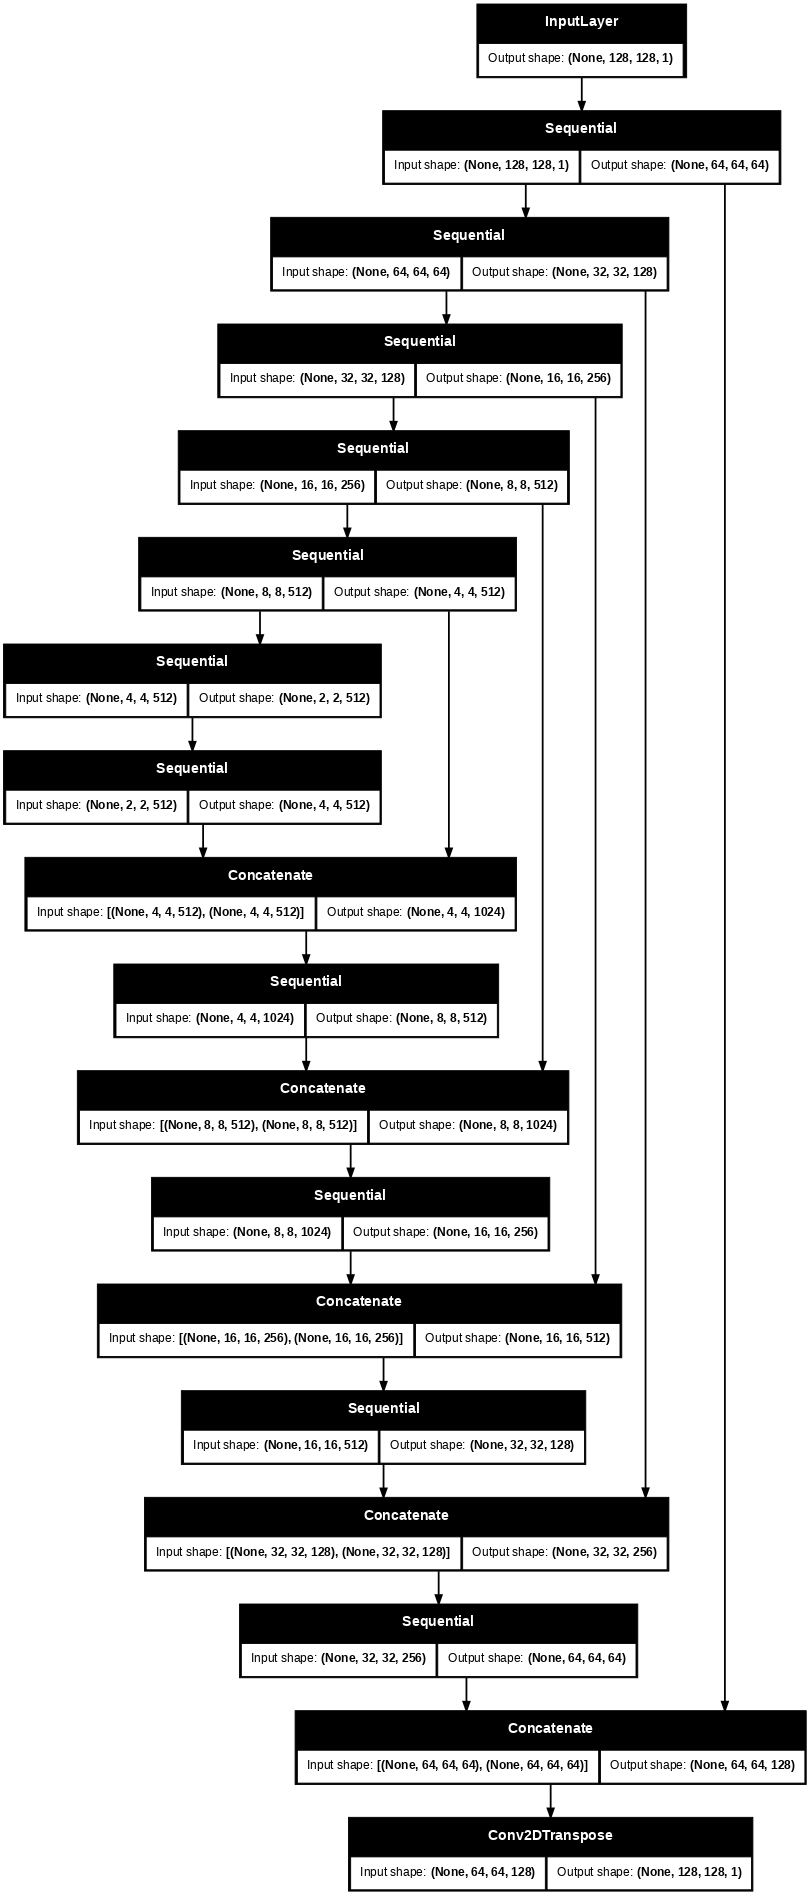

In [30]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

(1, 128, 128, 1)


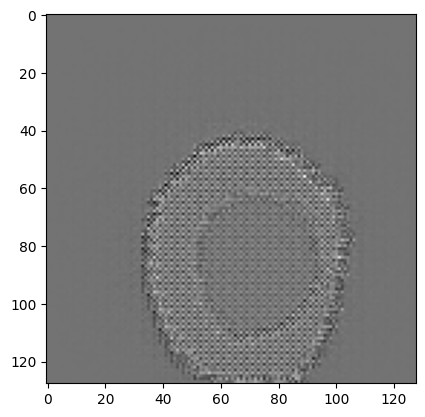

In [31]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
print(gen_output.shape)
plt.imshow(gen_output[0, ...],cmap="gray")

In [32]:
LAMBDA = 100

In [33]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
print(np.unique(inp))

[0. 1. 2.]


In [35]:
def generator_loss(disc_generated_output, gen_output, target, input_mask):
    # Original GAN loss component
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Create weight matrix for different regions
    weights = tf.where(input_mask == 3.0, 40.0, 1.0)  # Infarction (40x)
    weights = tf.where(input_mask == 4.0, 120.0, weights)  # No-reflow (120x)
    weights = tf.where(input_mask == 2.0, 20.0, weights)  # Normal myocardium (20x)
    weights = tf.where(input_mask == 1.0, 10.0, weights)  # Cavity (10x)

    # Expand weights to match image dimensions [batch, H, W, 1]
    weights = tf.expand_dims(weights, axis=-1)

    # Weighted L1 loss calculation
    l1_loss = tf.reduce_mean(weights * tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss


In [36]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 128, 128, 2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 64, 64, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 32, 32, 128)
    # down3 = downsample(256, 4)(down2)  # (batch_size, 16, 16, 256)
    # down4 = downsample(512, 4)(down3)  # (batch_size, 8, 8, 512)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 512)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

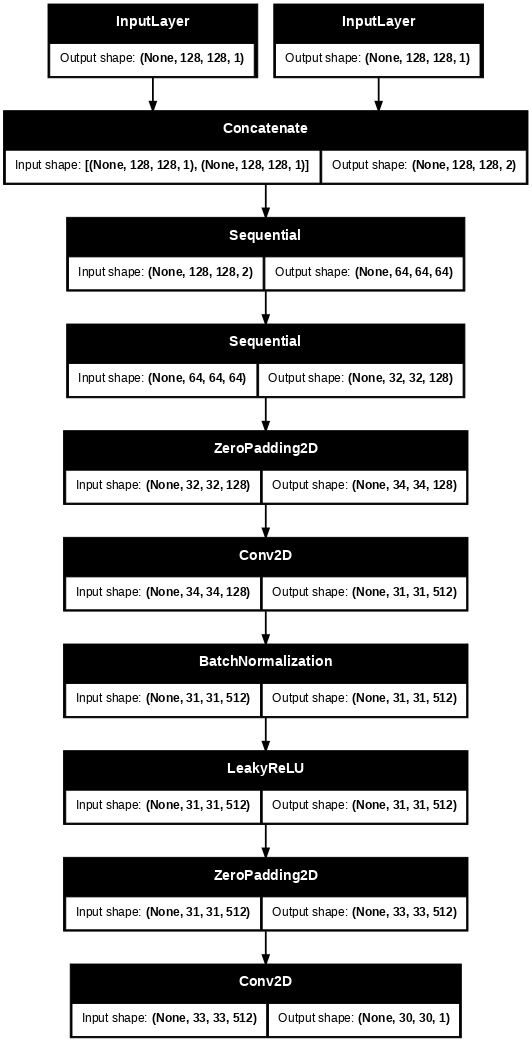

In [37]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

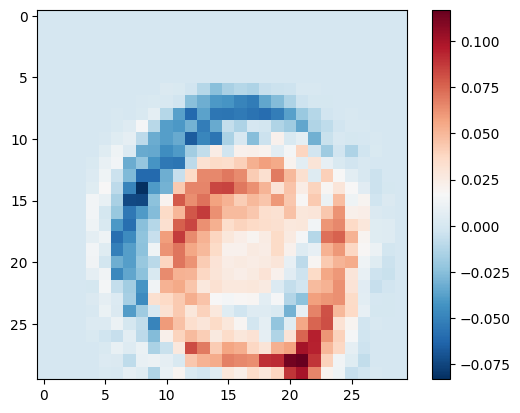

In [38]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

In [39]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [41]:
# Define checkpoint directory inside Google Drive
checkpoint_dir = '/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Define the checkpoint
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [42]:
best_checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    directory=checkpoint_dir + '/best_ckpt',
    max_to_keep=1
)

In [43]:
def generate_images(model, test_input, tar):
    test_input = tf.squeeze(test_input, axis=0)  # Remove batch dim
    tar = tf.squeeze(tar, axis=0)  # Remove batch dim
    prediction = model(tf.expand_dims(test_input, axis=0), training=True)
    prediction = tf.squeeze(prediction, axis=0)  # Remove batch dim after prediction

    cmap_mask = ListedColormap(['black', 'white', 'gray', 'red', 'yellow'])

    plt.figure(figsize=(15, 15))
    display_list = [test_input, tar, prediction]
    titles = ['Input Mask', 'Ground Truth (Grayscale)', 'Predicted Image (Grayscale)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])

        if i == 0:
            # Use the custom colormap for the mask
            plt.imshow(display_list[i], cmap=cmap_mask, vmin=0, vmax=4)
        else:
            # Use grayscale for ground truth and prediction
            plt.imshow(display_list[i], cmap='gray')

        plt.axis('off')

    plt.show()


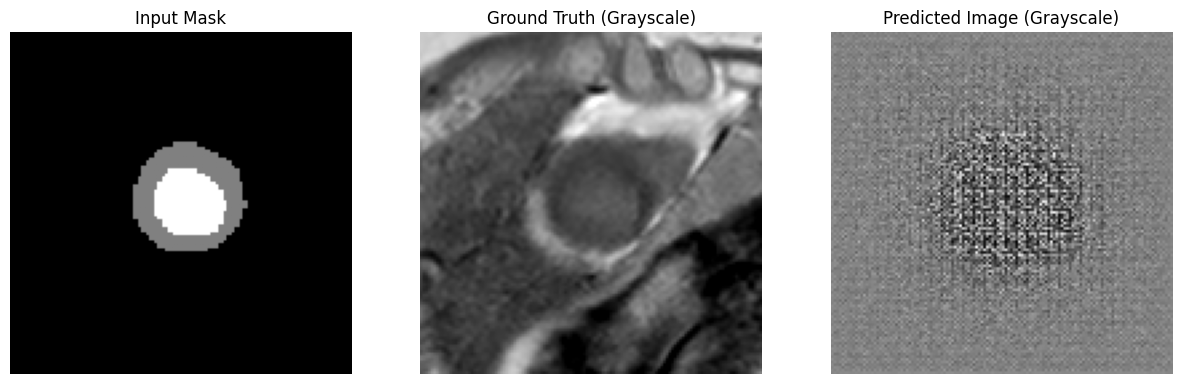

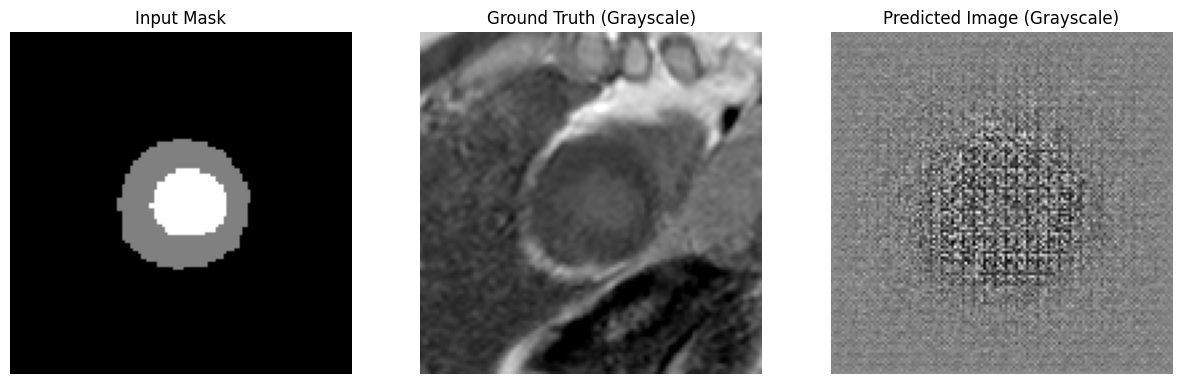

In [44]:
for example_input, example_target in test_dataset.take(2):
  generate_images(generator, example_input, example_target)

In [45]:
log_dir="/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [46]:
gen_total_loss_history = []
gen_gan_loss_history = []
gen_l1_loss_history = []
disc_loss_history = []
steps_history = []

In [47]:
best_gen_total_loss = float('inf')

In [48]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target, input_image)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

    # Return the losses (no need for .numpy() inside @tf.function)
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss


In [49]:
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(steps_history, gen_total_loss_history, label='Generator Total Loss')
    plt.plot(steps_history, gen_gan_loss_history, label='Generator GAN Loss')
    plt.plot(steps_history, gen_l1_loss_history, label='Generator L1 Loss')
    plt.plot(steps_history, disc_loss_history, label='Discriminator Loss')

    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid()
    plt.show()


In [50]:
loss_history_path = "/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/loss.csv"

In [51]:
import pandas as pd

def save_loss_to_drive():
    """Saves the loss history to a CSV file in Google Drive."""
    loss_data = {
        "Step": steps_history,
        "Gen_Total_Loss": gen_total_loss_history,
        "Gen_GAN_Loss": gen_gan_loss_history,
        "Gen_L1_Loss": gen_l1_loss_history,
        "Disc_Loss": disc_loss_history
    }

    # Convert to DataFrame
    df = pd.DataFrame(loss_data)

    # If the file exists, append without rewriting headers
    if os.path.exists(loss_history_path):
        df.to_csv(loss_history_path, mode='a', header=False, index=False)
        print("Loss history appended.")
    else:
        df.to_csv(loss_history_path, index=False)
        print("Loss history saved (new file created).")

In [52]:
def get_sample_by_index(dataset, index):
    for i, (x, y) in enumerate(dataset):
        if i == index:
            return x, y
    raise IndexError("Index out of range.")

In [53]:
def fit(train_ds, test_ds, steps):
  global best_gen_total_loss
  example_input, example_target = get_sample_by_index(test_dataset, 65)
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    # Call train_step() and store losses
    gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, step)

    # Convert tensors to NumPy and store in lists
    gen_total_loss_history.append(gen_total_loss.numpy())
    gen_gan_loss_history.append(gen_gan_loss.numpy())
    gen_l1_loss_history.append(gen_l1_loss.numpy())
    disc_loss_history.append(disc_loss.numpy())
    steps_history.append(step.numpy())

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Check for best model every 1000 steps
    if (step + 1) % 1000 == 0:
        current_loss = gen_total_loss.numpy()
        if current_loss < best_gen_total_loss:
            best_gen_total_loss = current_loss
            best_checkpoint_manager.save()
            print(f"\n✅ Best checkpoint updated at step {step.numpy()+1} with loss {best_gen_total_loss:.4f}")


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 10000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    # Plot loss every 5k steps
    if (step + 1) % 5000 == 0:
        save_loss_to_drive()
        plot_loss()

Time taken for 1000 steps: 59.02 sec



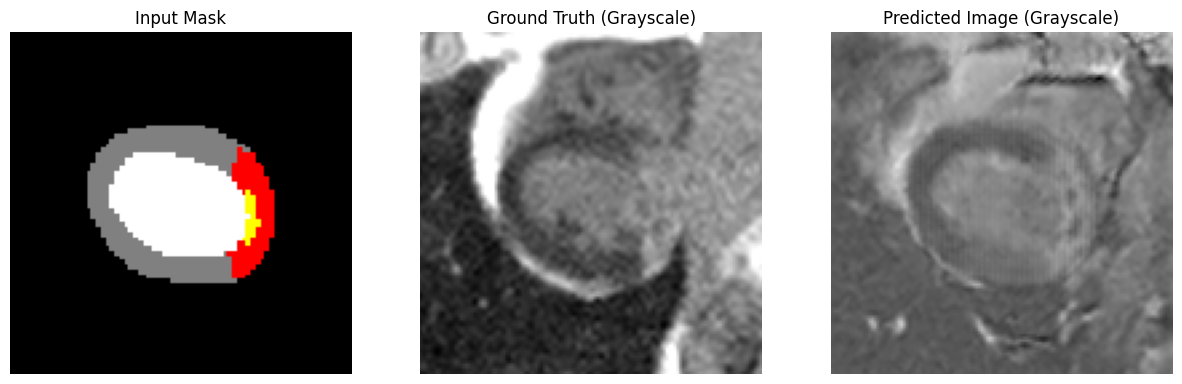

Step: 189k
....................................................................................................Loss history appended.


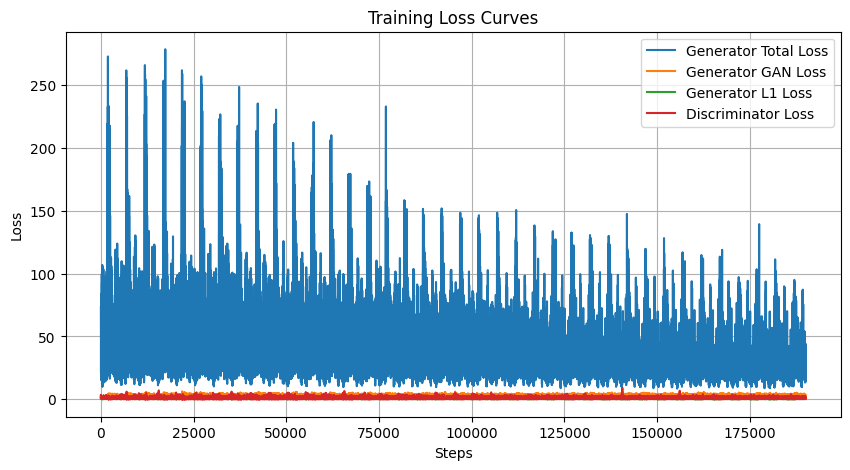

In [54]:
fit(train_dataset, test_dataset, steps=190000)

Loss history appended.


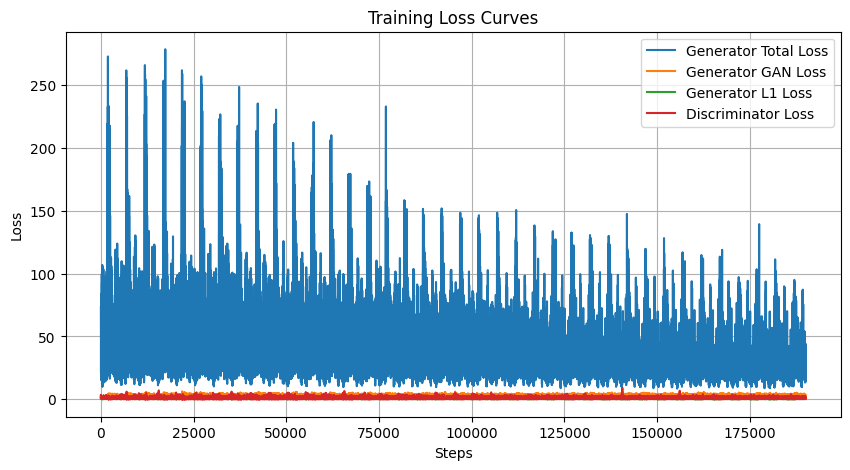

In [55]:
save_loss_to_drive()
plot_loss()

In [56]:
# Define a save path in Google Drive
save_dir = '/content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/model/'


In [57]:
# Save the entire model to the specified directory
model_save_path = os.path.join(save_dir, 'weightd_trained_model.h5')
generator.save(model_save_path)  # Save the generator model
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/model/weightd_trained_model.h5


In [58]:
# Save the entire model to the specified directory
model_save_path = os.path.join(save_dir, 'D_weightd_trained_model.h5')
discriminator.save(model_save_path)  # Save the generator model
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/filtered_basic_model_fully_augmented_data_200_128_30/model/D_weightd_trained_model.h5


In [59]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(99):
  generate_images(generator, inp, tar)

Output hidden; open in https://colab.research.google.com to view.